# Personalized User-level DP

In [1]:
import numpy as np

import os
path_project = os.path.dirname(os.path.abspath('.'))
import sys
sys.path.append(os.path.join(path_project, 'src'))
sys.path.append(os.path.join(path_project, 'exp/script'))

img_path = os.path.join(path_project, 'exp', 'img')
pickle_path = os.path.join(path_project, 'exp', 'pickle')
results_path = os.path.join(path_project, 'exp', 'results')

from personalized_utils import (
    init_heart_disease_param,
    make_q_c_curve, plot_q_c_curve, 
    make_epsilon_u, group_by_closest_below,
    static_optimization, show_static_optimization_result,
    prepare_grid_search,
    run_online_optimization, show_online_optimization_result,
    run_with_specified_idx, show_specified_idx_result,
    plot_acc_results,
)
from mylogger import logger_set_warning, logger_set_info


# qC curve

Given following parameters, the q C pair satisfying the privacy constraint has many candidates
- epsilon_u
- delta
- n_round
- sigma


Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/q_c_pair-example.png


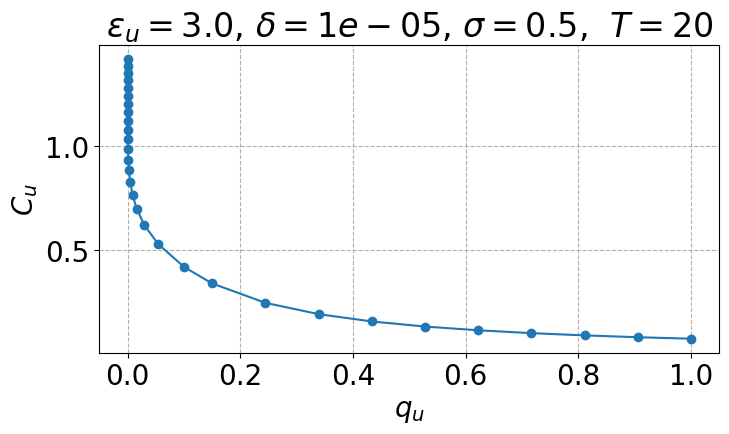

In [2]:
# Figure of q_c_pair.png
epsilon_u = 3.0
n_round = 20
delta = 1e-5
sigma = 0.5
x, y = make_q_c_curve(epsilon_u=epsilon_u, delta=delta, sigma=sigma, num_points=30, n_round=n_round, min=-6)
plot_q_c_curve(
    x, y,
    title=r"$\epsilon_u={}$, $\delta={}$, $\sigma={}$,  $T={}$".format(
                epsilon_u, delta, sigma, n_round,
            )
)

# PULDP-AVG

## Offline HPO

### HeartDisease

#### Parameters

#### Test with all of HPs for showing group-independency (Figure in Appendix)

Basic setting 

(This setup is close to the real world, and each group has a different number of users and different privacy budgets, so the optimal HP is likely to be different.)

- (eps1, eps2, eps3) = (0.15, 3.0, 5.0)
- with ratio (eps1, eps2, eps3) = (0.6, 0.25, 0.15)

In [3]:
sigma = 1.0
n_users = 400
epsilon_list = [0.15, 3.0, 5.0]
group_thresholds = epsilon_list
ratio_list = [0.6, 0.25, 0.15]
delta = 1e-5
n_round = 20
dataset_name = 'heart_disease'
q_step_size = None
times = 10
validation_ratio = 0.0
static_q_u_list = [1.0, 0.9, 0.8, 0.7, 0.5, 0.3, 0.1]
global_learning_rate=0.5
local_learning_rate=0.001
local_epochs=30

random_state = np.random.RandomState(0)
epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
grouped = group_by_closest_below(epsilon_u_dct=epsilon_u, group_thresholds=group_thresholds)
epsilon_u = {}
for eps_u, user_ids in grouped.items():
    for user_id in user_ids:
        epsilon_u[user_id] = eps_u
opt_strategy = prepare_grid_search(epsilon_u, start_idx=0, end_idx=7)

logger_set_warning()
static_optimization(
    epsilon_u, sigma, delta, n_users, n_round, dataset_name, times, 
    q_step_size, opt_strategy=opt_strategy, validation_ratio=validation_ratio, 
    user_dist="uniform-iid", silo_dist="uniform", 
    static_q_u_list=static_q_u_list, global_learning_rate=global_learning_rate, 
    local_learning_rate=local_learning_rate, local_epochs=local_epochs, 
)
min_idx, min_loss = show_static_optimization_result(
    epsilon_u, sigma, delta, n_users, n_round, dataset_name, 
    q_step_size, n_silos=4, opt_strategy=opt_strategy, validation_ratio=validation_ratio,
    train_loss=False, img_name=f"heart_disease-users-{n_users}", is_3d=True, 
    static_q_u_list=static_q_u_list, user_dist="uniform-iid", global_learning_rate=global_learning_rate, 
    local_learning_rate=local_learning_rate, local_epochs=local_epochs, 
)
print(f"min_idx = {min_idx}, min_loss = {min_loss}")

SyntaxError: keyword argument repeated: global_learning_rate (2133653899.py, line 27)

#### Various n_users with a single eps group (Fig in Sec4)

Skip: File already exists.
Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/static_optimization_result-1d-heart_disease-users-50.png


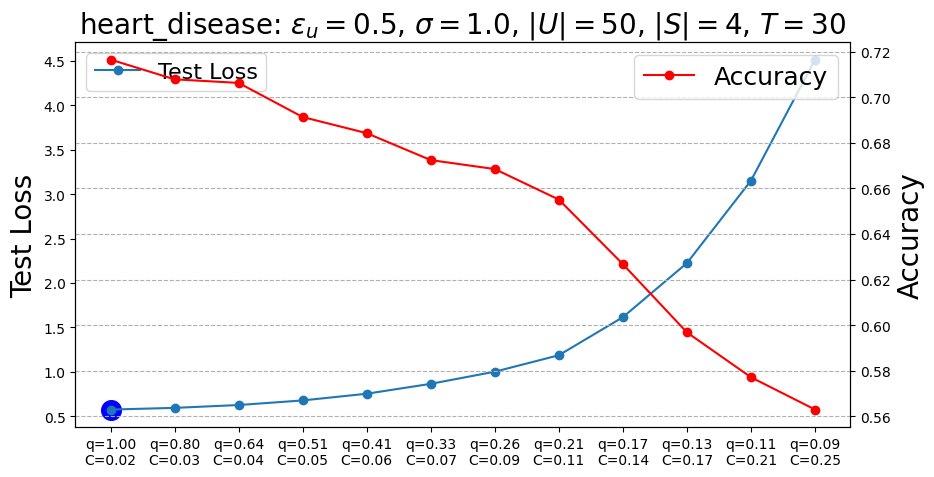

{0.5: 0} 0.5754557847976685
Skip: File already exists.
Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/static_optimization_result-1d-heart_disease-users-100.png


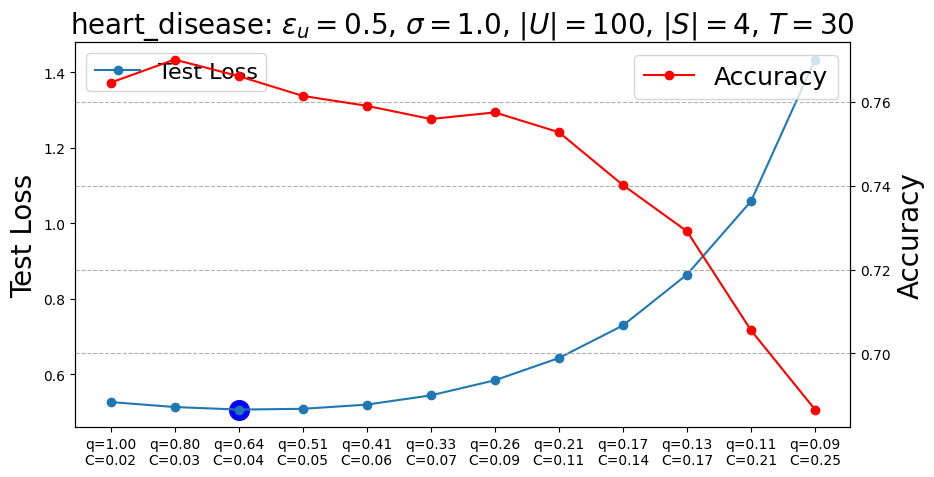

{0.5: 2} 0.5067352712154388
Skip: File already exists.
Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/static_optimization_result-1d-heart_disease-users-200.png


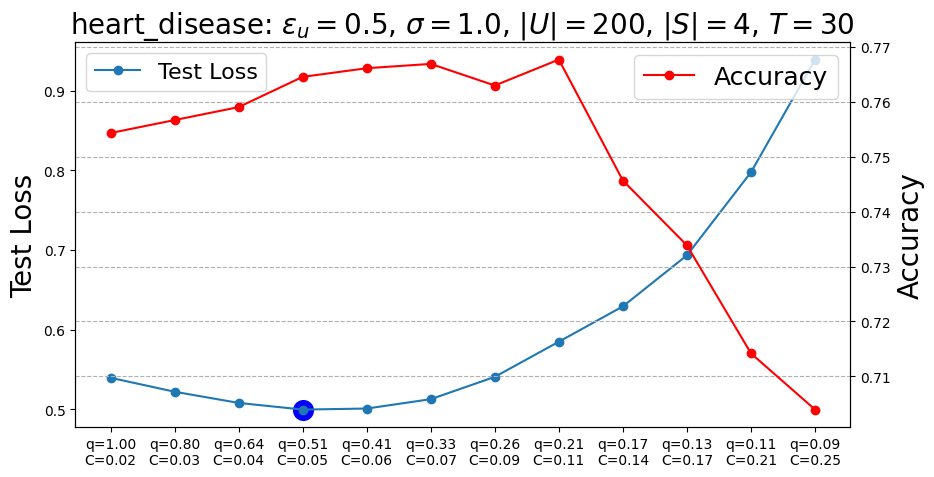

{0.5: 3} 0.49974275231361387
Skip: File already exists.
Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/static_optimization_result-1d-heart_disease-users-400.png


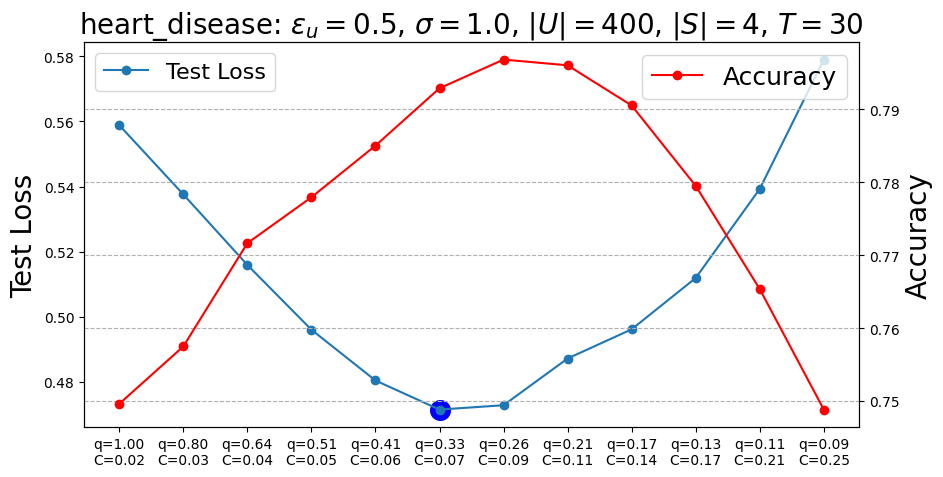

{0.5: 5} 0.4715360403060913


In [11]:
logger_set_warning()
fed_sim_params = init_heart_disease_param(eps_u=0.5, parallelized=True)

for n_users in [50, 100, 200, 400]:
    fed_sim_params.n_users = n_users
    idx_per_group_list = prepare_grid_search(fed_sim_params.get_group_eps_set(), start_idx=0, end_idx=12)
    static_optimization(fed_sim_params, idx_per_group_list, static_q_u_list=None, force_update=False)
    min_idx, min_loss = show_static_optimization_result(
        fed_sim_params, idx_per_group_list, 
        img_name=f"heart_disease-users-{n_users}"
    )
    print(min_idx, min_loss)

#### Various eps_u with a single eps group (Fig in Sec4)

Skip: File already exists.
Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/static_optimization_result-1d-heart_disease-uniform-eps-0.15.png


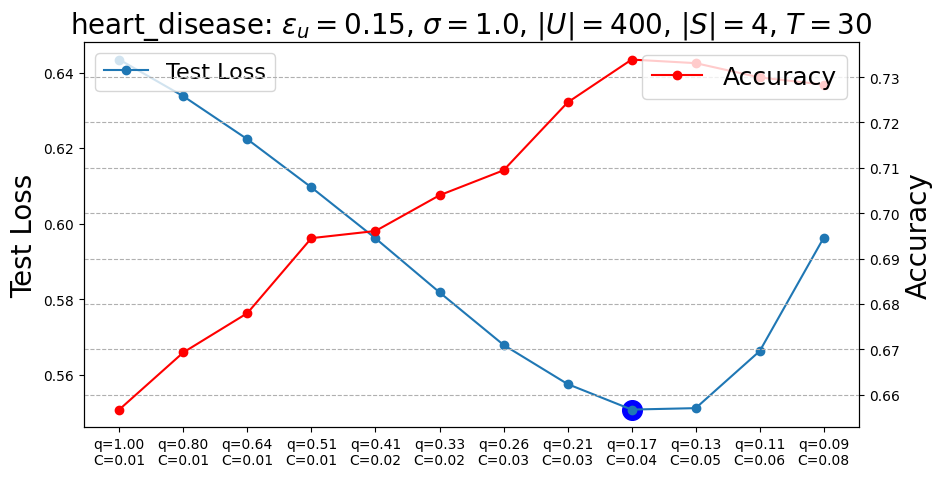

{0.15: 8} 0.5507778882980346
Skip: File already exists.
Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/static_optimization_result-1d-heart_disease-uniform-eps-0.5.png


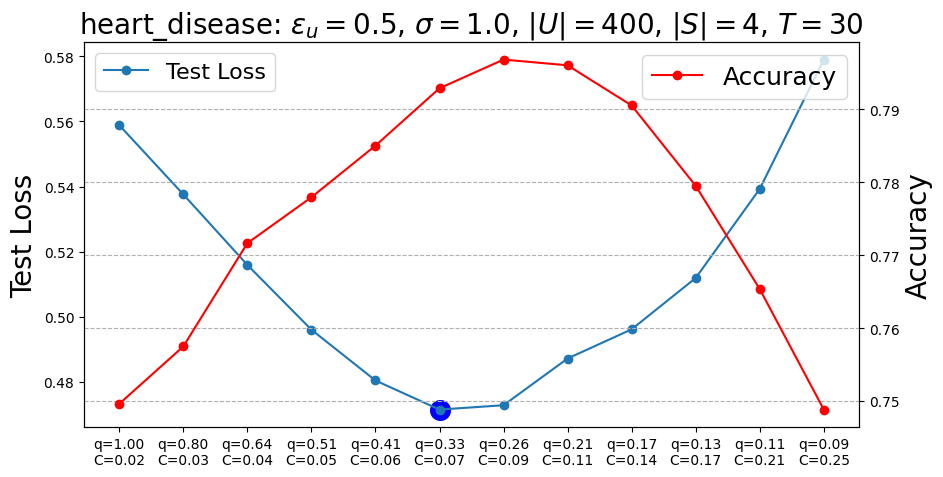

{0.5: 5} 0.4715360403060913
IDX:  {1.0: 0}
======== TIME: 0 start
======== TIME: 1 start
======== TIME: 2 start
======== TIME: 3 start
======== TIME: 4 start
IDX:  {1.0: 1}
======== TIME: 0 start
======== TIME: 1 start
======== TIME: 2 start
======== TIME: 3 start
======== TIME: 4 start
IDX:  {1.0: 2}
======== TIME: 0 start
======== TIME: 1 start
======== TIME: 2 start
======== TIME: 3 start
======== TIME: 4 start
IDX:  {1.0: 3}
======== TIME: 0 start
======== TIME: 1 start
======== TIME: 2 start
======== TIME: 3 start
======== TIME: 4 start
IDX:  {1.0: 4}
======== TIME: 0 start
======== TIME: 1 start
======== TIME: 2 start
======== TIME: 3 start
======== TIME: 4 start
IDX:  {1.0: 5}
======== TIME: 0 start
======== TIME: 1 start
======== TIME: 2 start
======== TIME: 3 start
======== TIME: 4 start
IDX:  {1.0: 6}
======== TIME: 0 start
======== TIME: 1 start
======== TIME: 2 start
======== TIME: 3 start
======== TIME: 4 start
IDX:  {1.0: 7}
======== TIME: 0 start
======== TIME: 1 start
=

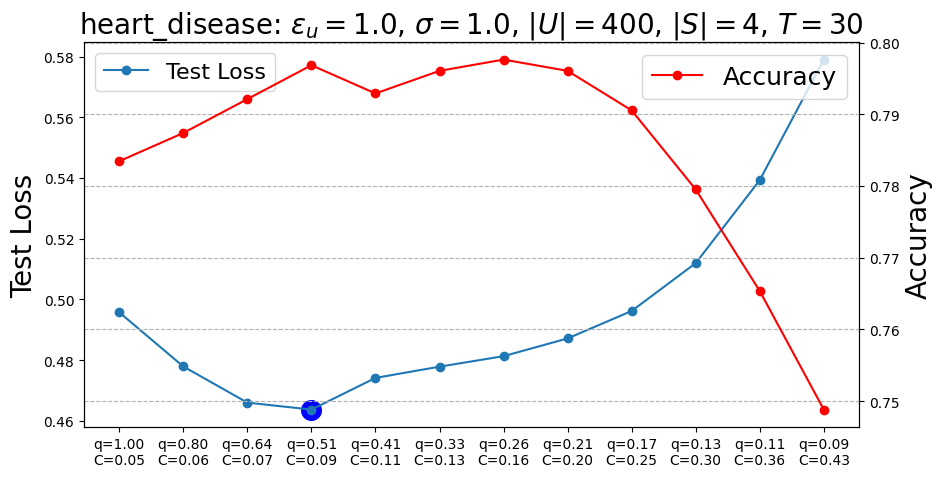

{1.0: 3} 0.46369879245758056
Skip: File already exists.
Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/static_optimization_result-1d-heart_disease-uniform-eps-5.0.png


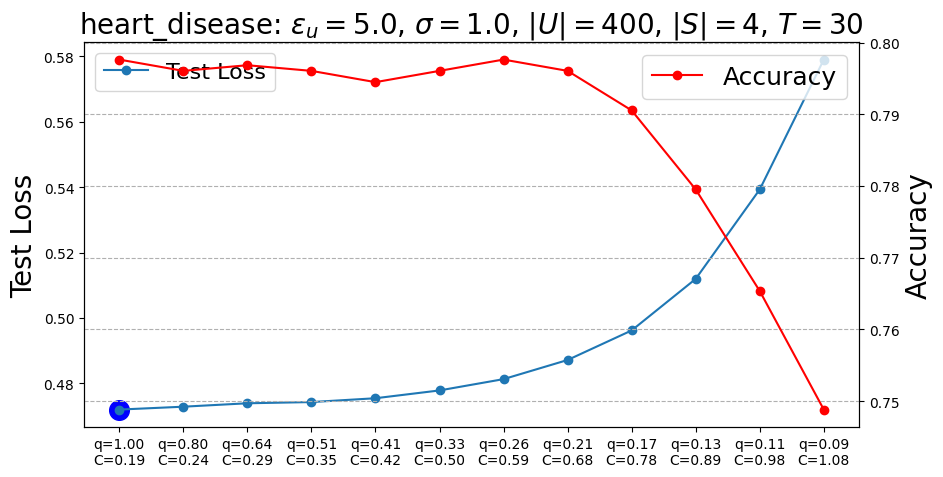

{5.0: 0} 0.4719789981842041


In [7]:
for eps_u in [0.15, 0.5, 1.0, 5.0]:
    fed_sim_params = init_heart_disease_param(eps_u=eps_u, parallelized=True)
    idx_per_group_list = prepare_grid_search(fed_sim_params.get_group_eps_set(), start_idx=0, end_idx=12)
    static_optimization(fed_sim_params, idx_per_group_list, static_q_u_list=None, force_update=False)
    min_idx, min_loss = show_static_optimization_result(
        fed_sim_params, idx_per_group_list, 
        img_name=f"heart_disease-uniform-eps-{eps_u}"
    )
    print(min_idx, min_loss)

#### for ULDP-AVG

Skip: File already exists.
Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/static_optimization_result-1d-heart_disease-uldpavg.png


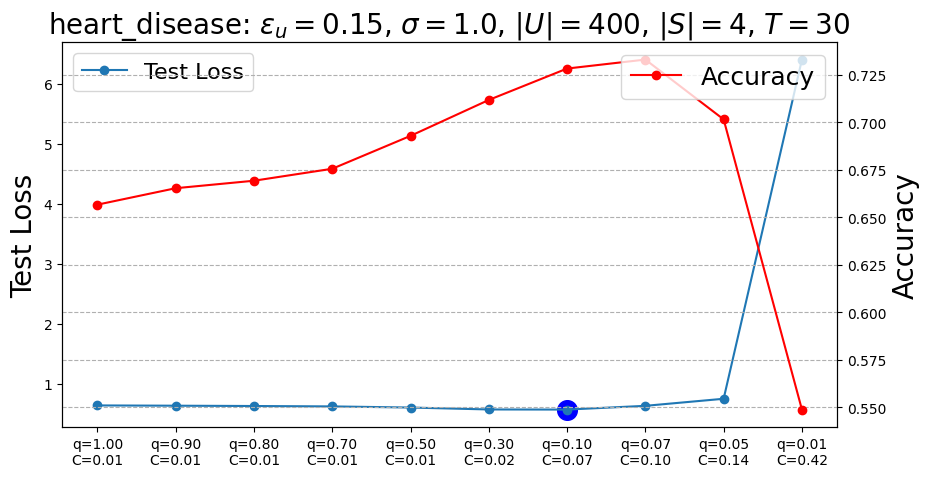

min_idx = {0.15: 6}, min_loss = 0.5743536829948426


In [10]:
static_q_u_list = [1.0, 0.9, 0.8, 0.7, 0.5, 0.3, 0.1, 0.07, 0.05, 0.01]
fed_sim_params = init_heart_disease_param(eps_u=0.15, parallelized=True)
idx_per_group_list = prepare_grid_search(fed_sim_params.get_group_eps_set(), start_idx=0, end_idx=10)
static_optimization(fed_sim_params, idx_per_group_list, static_q_u_list=static_q_u_list, force_update=False)
min_idx, min_loss = show_static_optimization_result(
    fed_sim_params, idx_per_group_list, 
    static_q_u_list=static_q_u_list,
    img_name=f"{fed_sim_params.dataset_name}-uldpavg",
)
print(f"min_idx = {min_idx}, min_loss = {min_loss}")

## Online HPO

### HeartDisease

#### QCTest

##### different initial q_u

Skip: File already exists.
Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/online_optimization_result-heart_disease-PULDP-AVG-QCTest-0.1.png


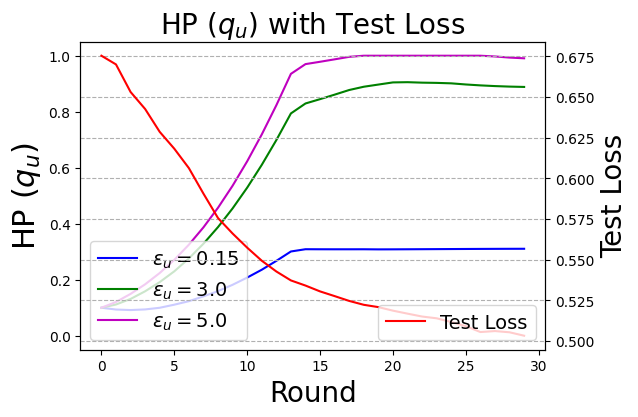

Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/online_optimization_result-losses-heart_disease-PULDP-AVG-QCTest-0.1.png


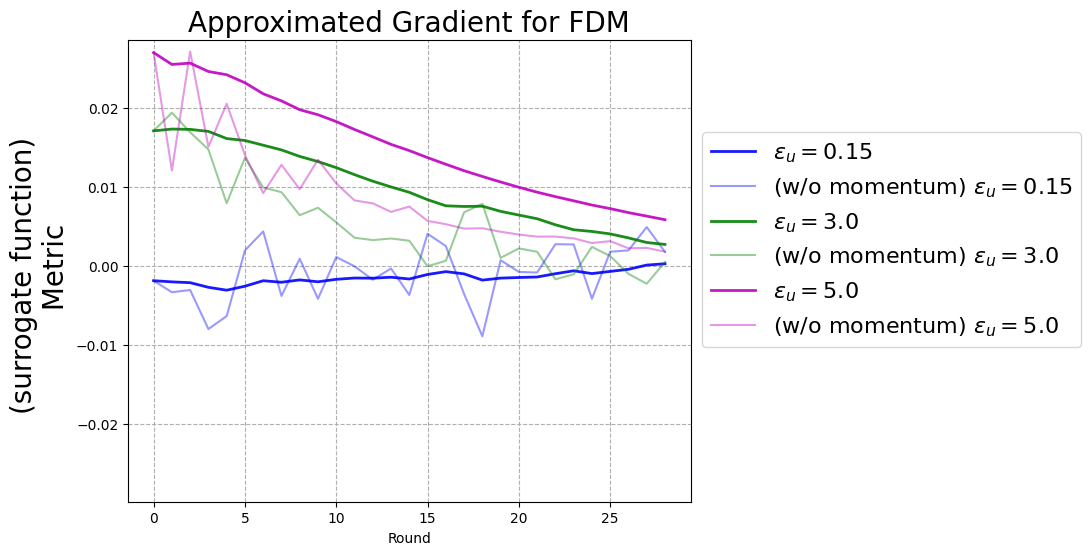

Skip: File already exists.
Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/online_optimization_result-heart_disease-PULDP-AVG-QCTest-0.5.png


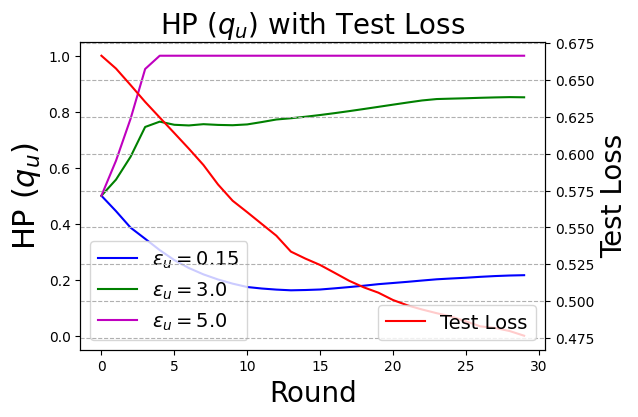

Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/online_optimization_result-losses-heart_disease-PULDP-AVG-QCTest-0.5.png


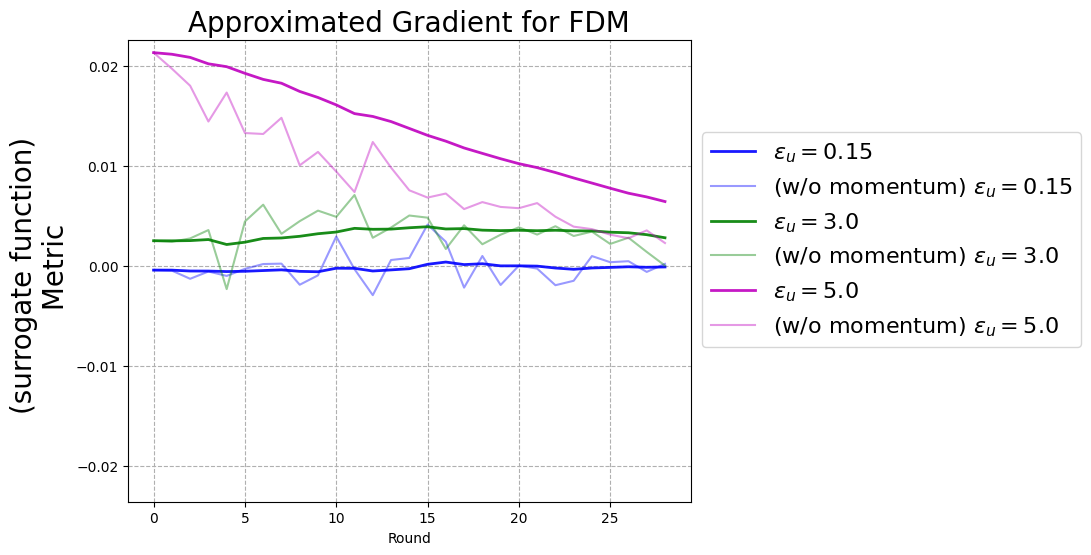

Skip: File already exists.
Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/online_optimization_result-heart_disease-PULDP-AVG-QCTest-1.0.png


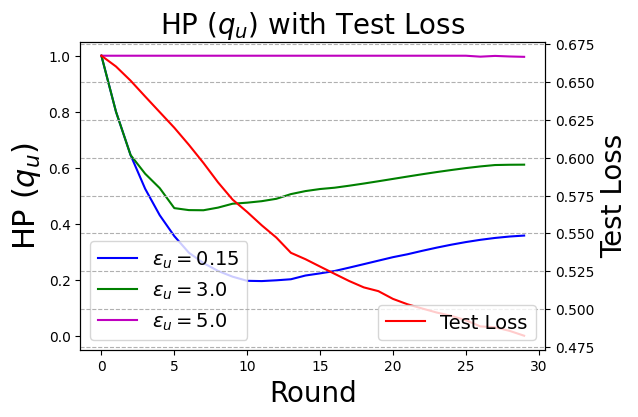

Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/online_optimization_result-losses-heart_disease-PULDP-AVG-QCTest-1.0.png


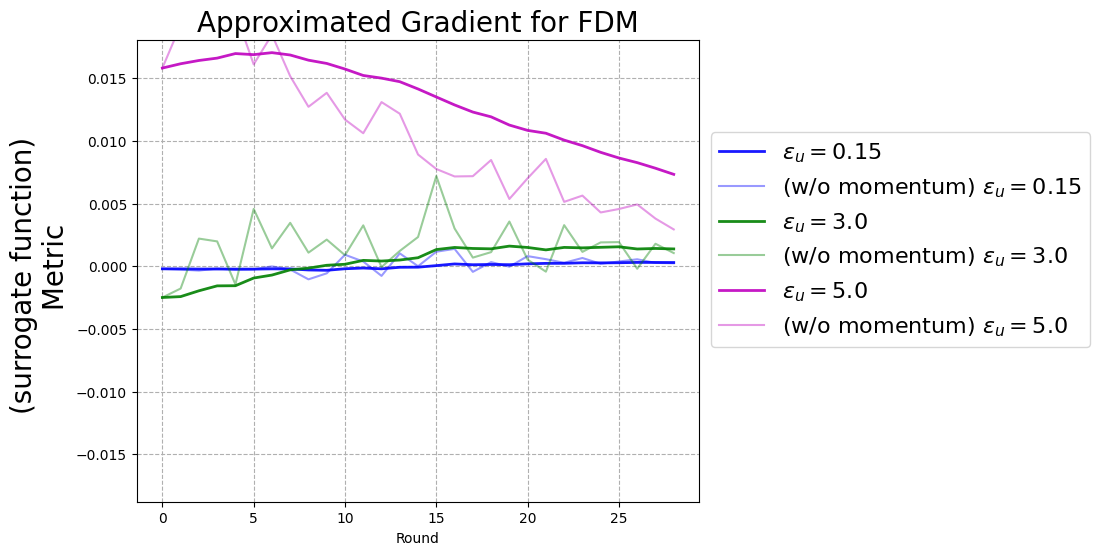

In [12]:
if "hd_all_acc_results" not in locals():
    hd_all_acc_results = {}
logger_set_warning()
fed_sim_params = init_heart_disease_param(parallelized=True)
fed_sim_params.epsilon_list = [0.15, 3.0, 5.0]
fed_sim_params.group_thresholds = [0.15, 3.0, 5.0]
fed_sim_params.ratio_list = [0.6, 0.25, 0.15]
fed_sim_params.validation_ratio = 0.5
fed_sim_params.times = 10
fed_sim_params.agg_strategy = "PULDP-AVG-QCTest"

initial_q_u_list = [0.1, 0.5, 1.0]
for initial_q_u in initial_q_u_list:
    fed_sim_params.initial_q_u = initial_q_u
    run_online_optimization(fed_sim_params, force_update=False)
    x, acc_means, acc_stds = show_online_optimization_result(
        fed_sim_params, errorbar=False,
        img_name=f"{fed_sim_params.dataset_name}-{fed_sim_params.agg_strategy}-{initial_q_u}"
    )
    hd_all_acc_results[(fed_sim_params.agg_strategy, initial_q_u)] = (x, acc_means, acc_stds)


##### different (bigger) step size

======== TIME: 0 start
======== TIME: 1 start
======== TIME: 2 start
======== TIME: 3 start
======== TIME: 4 start
======== TIME: 5 start
======== TIME: 6 start
======== TIME: 7 start
======== TIME: 8 start
======== TIME: 9 start
TEST ACC: 0.7402 ± 0.0423 , TEST LOSS: 0.5234 ± 0.0485
VALID ACC: 0.7606 ± 0.0652 , VALID LOSS: 0.5180 ± 0.0522
Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/online_optimization_result-heart_disease-PULDP-AVG-QCTest-0.1.png


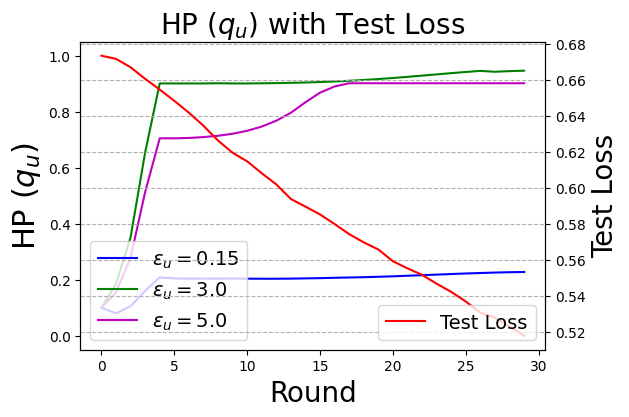

Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/online_optimization_result-losses-heart_disease-PULDP-AVG-QCTest-0.1.png


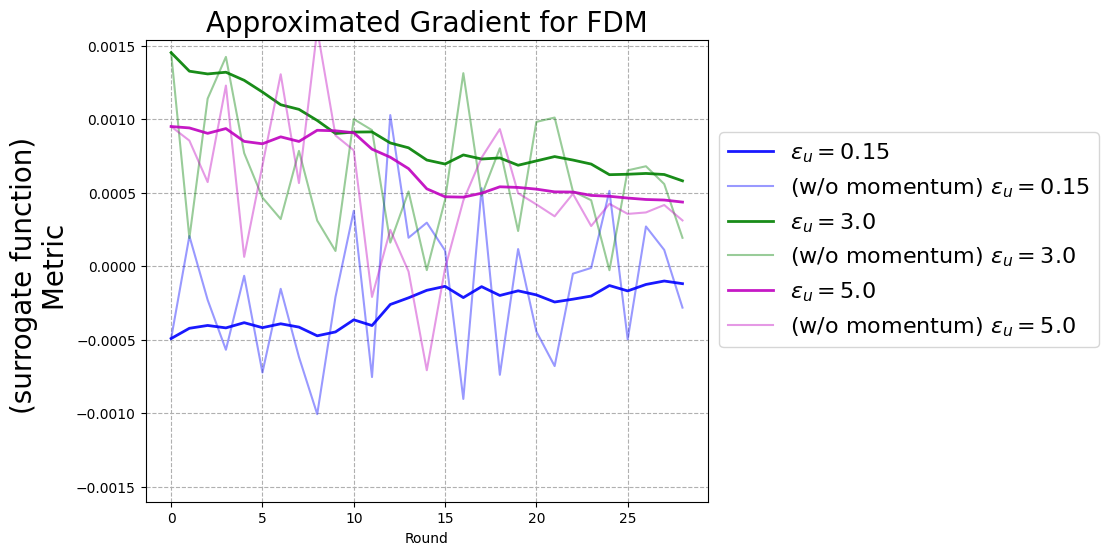

======== TIME: 0 start
======== TIME: 1 start
======== TIME: 2 start
======== TIME: 3 start
======== TIME: 4 start
======== TIME: 5 start
======== TIME: 6 start
======== TIME: 7 start
======== TIME: 8 start
======== TIME: 9 start
TEST ACC: 0.7457 ± 0.0478 , TEST LOSS: 0.5167 ± 0.0485
VALID ACC: 0.7709 ± 0.0564 , VALID LOSS: 0.5104 ± 0.0506
Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/online_optimization_result-heart_disease-PULDP-AVG-QCTest-0.5.png


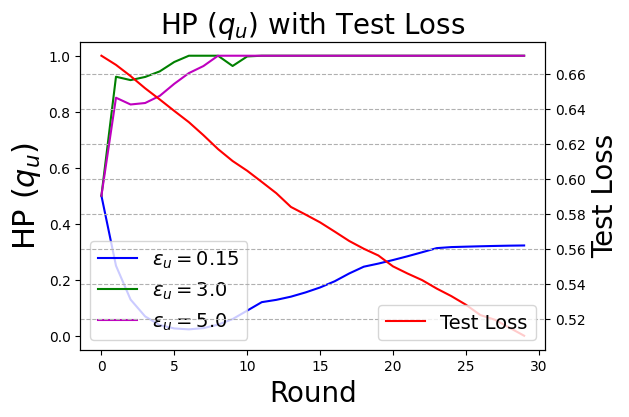

Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/online_optimization_result-losses-heart_disease-PULDP-AVG-QCTest-0.5.png


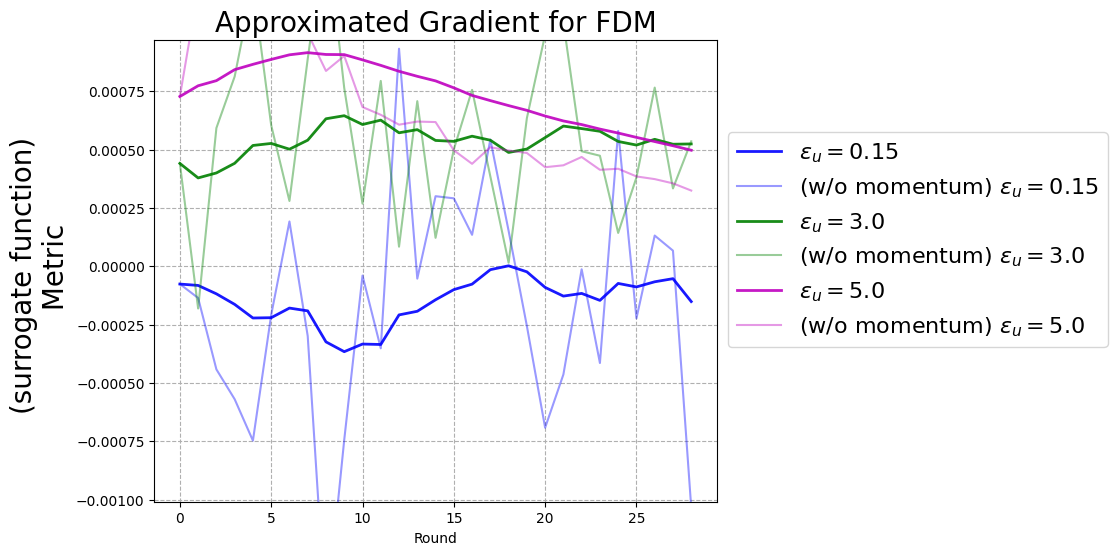

======== TIME: 0 start
======== TIME: 1 start
======== TIME: 2 start
======== TIME: 3 start
======== TIME: 4 start
======== TIME: 5 start
======== TIME: 6 start
======== TIME: 7 start
======== TIME: 8 start
======== TIME: 9 start
TEST ACC: 0.7370 ± 0.0629 , TEST LOSS: 0.5276 ± 0.0505
VALID ACC: 0.7535 ± 0.0744 , VALID LOSS: 0.5213 ± 0.0582
Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/online_optimization_result-heart_disease-PULDP-AVG-QCTest-1.0.png


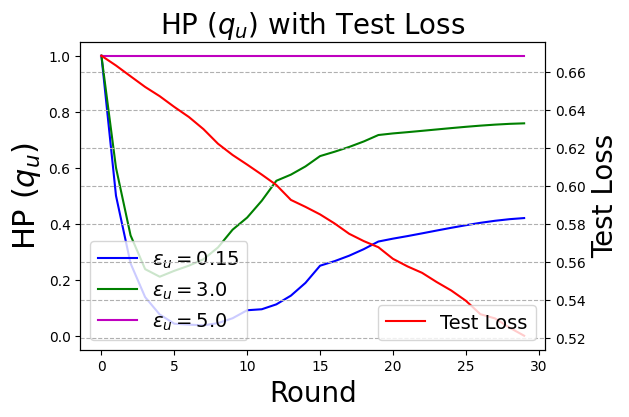

Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/online_optimization_result-losses-heart_disease-PULDP-AVG-QCTest-1.0.png


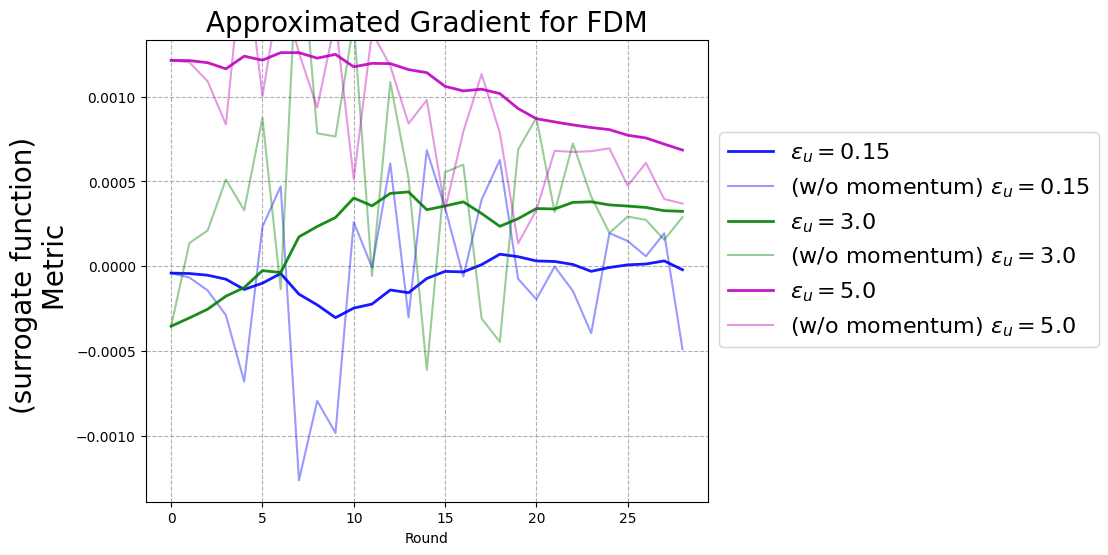

In [ ]:
logger_set_warning()
fed_sim_params = init_heart_disease_param(parallelized=True)
fed_sim_params.epsilon_list = [0.15, 3.0, 5.0]
fed_sim_params.group_thresholds = [0.15, 3.0, 5.0]
fed_sim_params.ratio_list = [0.6, 0.25, 0.15]
fed_sim_params.validation_ratio = 0.5
fed_sim_params.times = 10
fed_sim_params.agg_strategy = "PULDP-AVG-QCTest"

initial_q_u_list = [0.1, 0.5, 1.0]
q_step_size_list = [0.3, 0.5, 1.0]
for initial_q_u in initial_q_u_list:
    for q_step_size in q_step_size_list:
        fed_sim_params.initial_q_u = initial_q_u
        fed_sim_params.q_step_size = q_step_size
        run_online_optimization(fed_sim_params, force_update=False)
        x, acc_means, acc_stds = show_online_optimization_result(
            fed_sim_params, errorbar=False,
            img_name=f"{fed_sim_params.dataset_name}-{fed_sim_params.agg_strategy}-{initial_q_u}-q_step_size{q_step_size}"
        )

##### different momentum_weight

======== TIME: 0 start
======== TIME: 1 start
======== TIME: 2 start
======== TIME: 3 start
======== TIME: 4 start
======== TIME: 5 start
======== TIME: 6 start
======== TIME: 7 start
======== TIME: 8 start
======== TIME: 9 start
TEST ACC: 0.7465 ± 0.0603 , TEST LOSS: 0.5170 ± 0.0511
VALID ACC: 0.7669 ± 0.0676 , VALID LOSS: 0.5107 ± 0.0546
Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/online_optimization_result-heart_disease-PULDP-AVG-QCTest-0.1.png


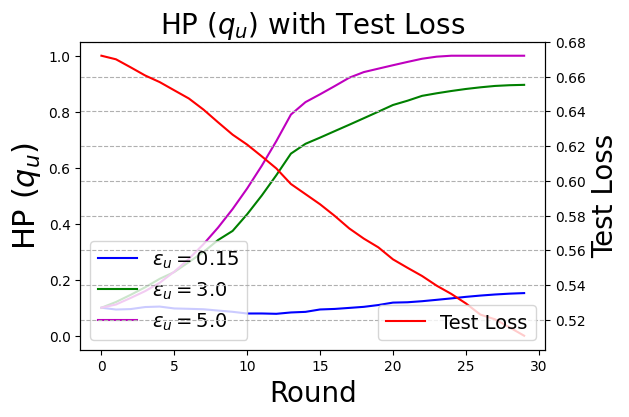

Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/online_optimization_result-losses-heart_disease-PULDP-AVG-QCTest-0.1.png


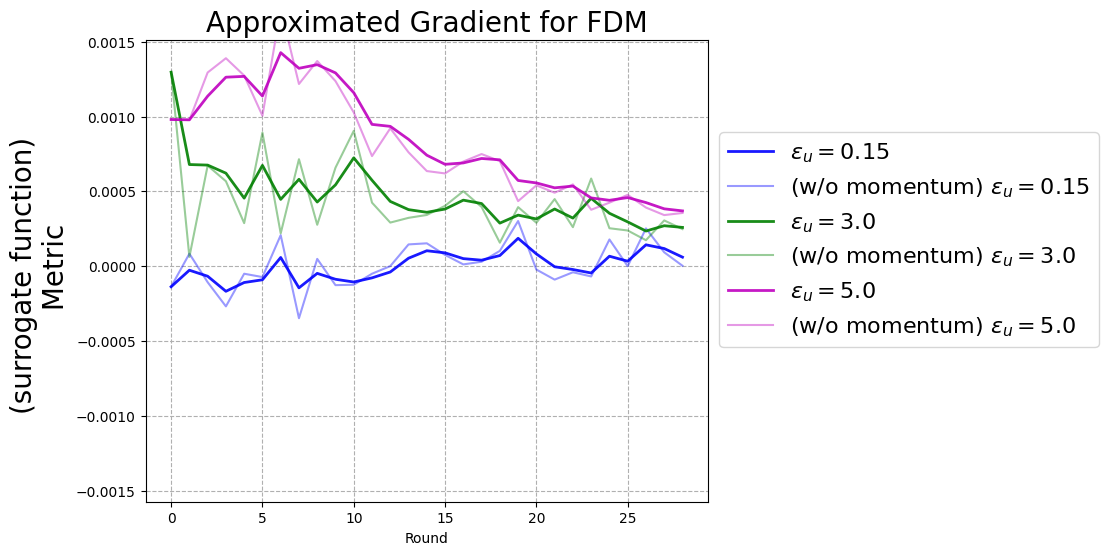

======== TIME: 0 start
======== TIME: 1 start
======== TIME: 2 start
======== TIME: 3 start
======== TIME: 4 start
======== TIME: 5 start
======== TIME: 6 start
======== TIME: 7 start
======== TIME: 8 start
======== TIME: 9 start
TEST ACC: 0.7559 ± 0.0305 , TEST LOSS: 0.4945 ± 0.0439
VALID ACC: 0.7866 ± 0.0438 , VALID LOSS: 0.4849 ± 0.0446
Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/online_optimization_result-heart_disease-PULDP-AVG-QCTest-0.5.png


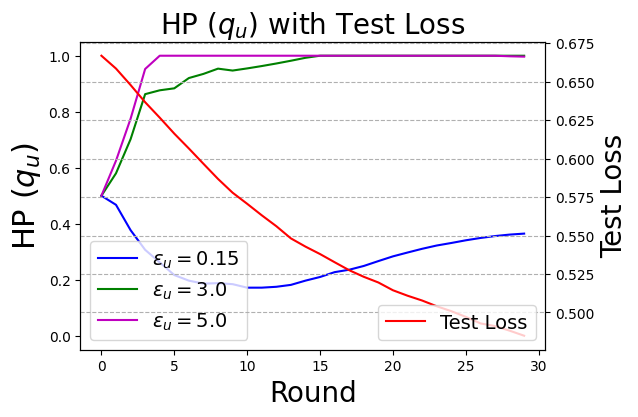

Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/online_optimization_result-losses-heart_disease-PULDP-AVG-QCTest-0.5.png


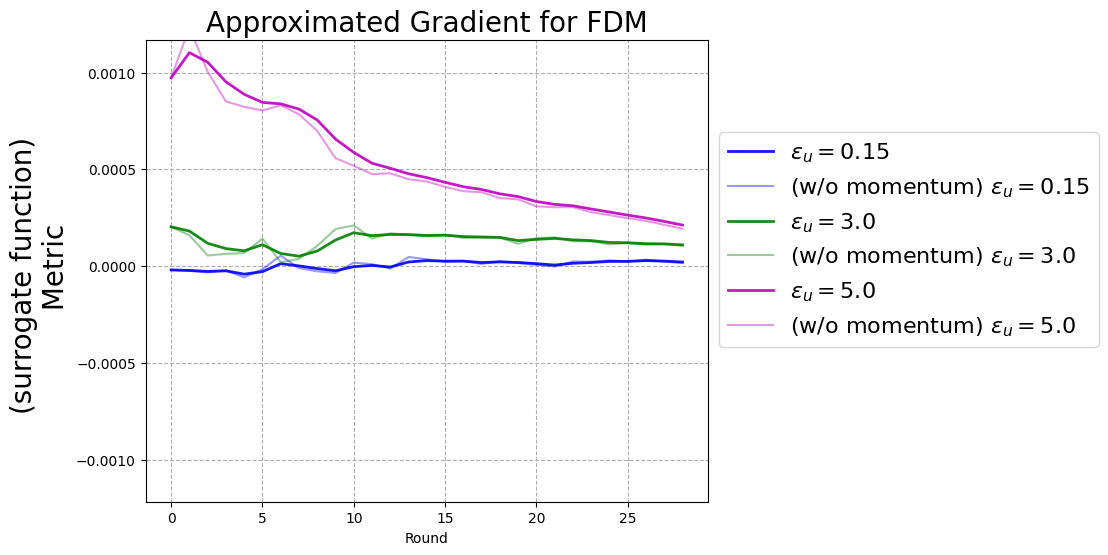

======== TIME: 0 start
======== TIME: 1 start
======== TIME: 2 start
======== TIME: 3 start
======== TIME: 4 start
======== TIME: 5 start
======== TIME: 6 start
======== TIME: 7 start
======== TIME: 8 start
======== TIME: 9 start
TEST ACC: 0.7559 ± 0.0293 , TEST LOSS: 0.4928 ± 0.0440
VALID ACC: 0.7921 ± 0.0389 , VALID LOSS: 0.4834 ± 0.0446
Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/online_optimization_result-heart_disease-PULDP-AVG-QCTest-1.0.png


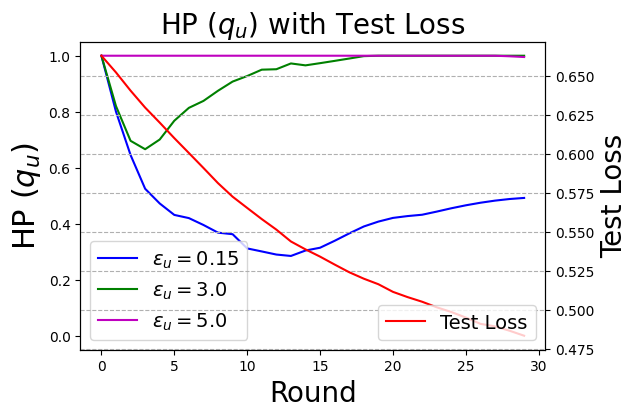

Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/online_optimization_result-losses-heart_disease-PULDP-AVG-QCTest-1.0.png


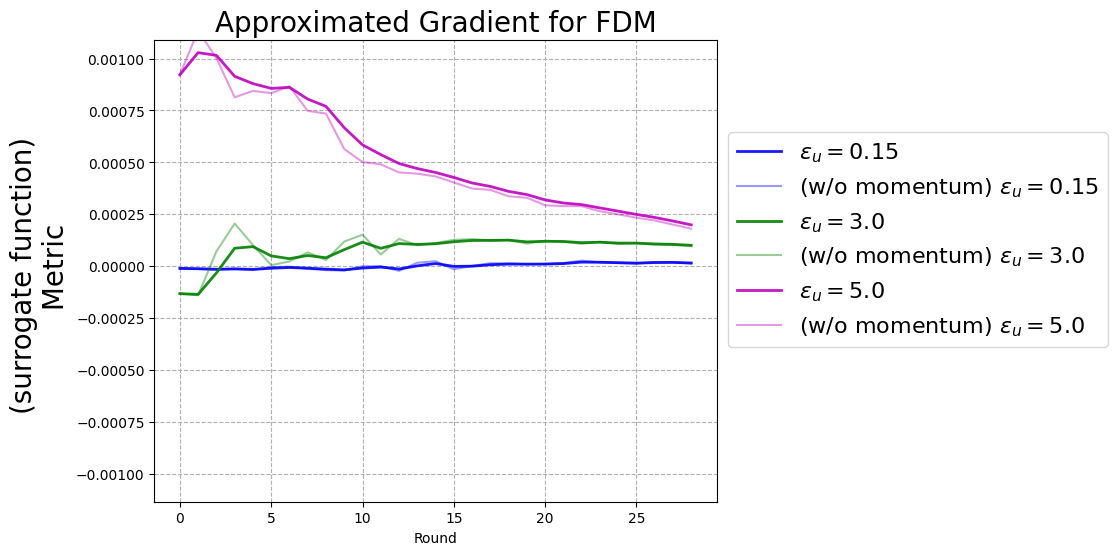

======== TIME: 0 start
======== TIME: 1 start
======== TIME: 2 start
======== TIME: 3 start
======== TIME: 4 start
======== TIME: 5 start
======== TIME: 6 start
======== TIME: 7 start
======== TIME: 8 start
======== TIME: 9 start
TEST ACC: 0.7331 ± 0.0778 , TEST LOSS: 0.5246 ± 0.0663
VALID ACC: 0.7543 ± 0.0873 , VALID LOSS: 0.5192 ± 0.0668
Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/online_optimization_result-heart_disease-PULDP-AVG-QCTest-0.1.png


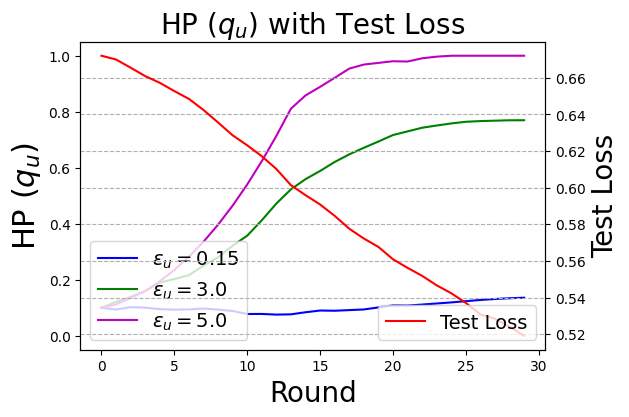

Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/online_optimization_result-losses-heart_disease-PULDP-AVG-QCTest-0.1.png


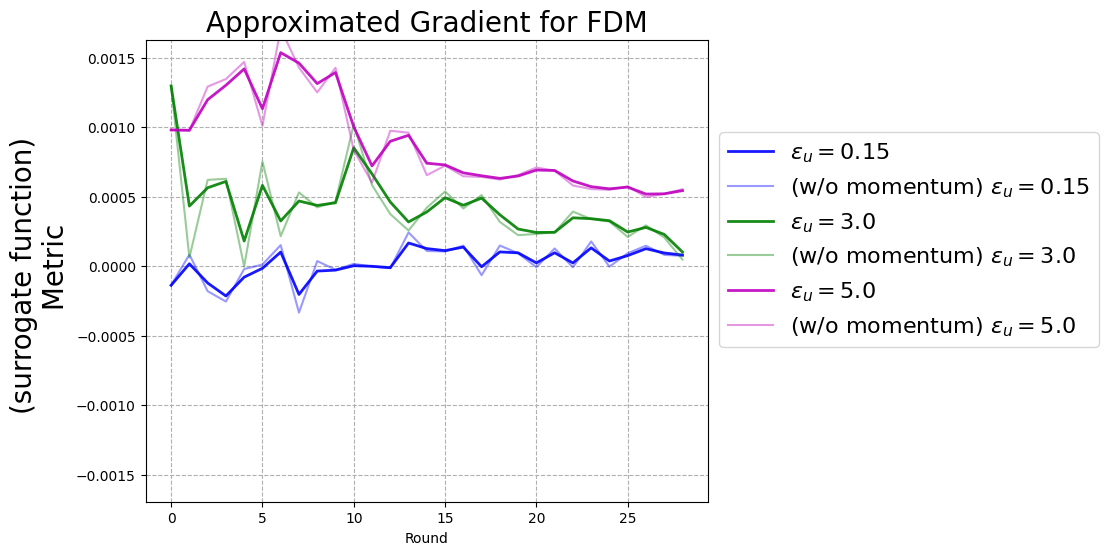

======== TIME: 0 start
======== TIME: 1 start
======== TIME: 2 start
======== TIME: 3 start
======== TIME: 4 start
======== TIME: 5 start
======== TIME: 6 start
======== TIME: 7 start
======== TIME: 8 start
======== TIME: 9 start
TEST ACC: 0.7559 ± 0.0305 , TEST LOSS: 0.4942 ± 0.0434
VALID ACC: 0.7882 ± 0.0436 , VALID LOSS: 0.4847 ± 0.0441
Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/online_optimization_result-heart_disease-PULDP-AVG-QCTest-0.5.png


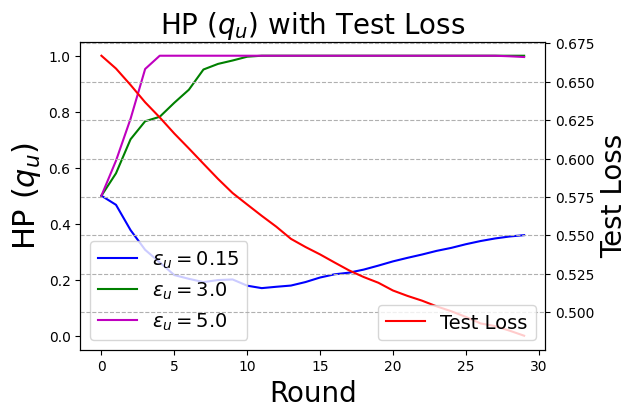

Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/online_optimization_result-losses-heart_disease-PULDP-AVG-QCTest-0.5.png


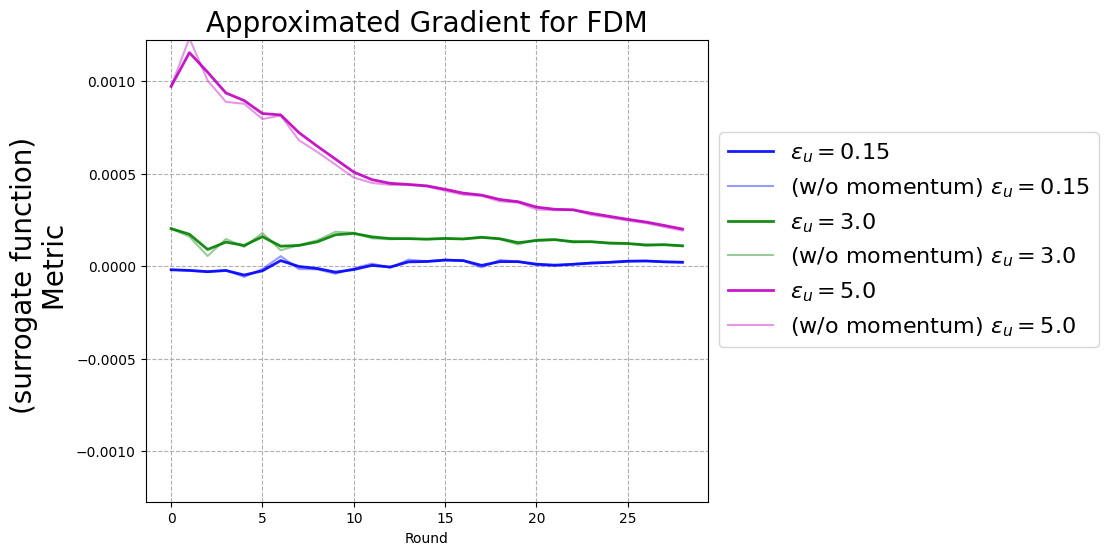

======== TIME: 0 start
======== TIME: 1 start
======== TIME: 2 start
======== TIME: 3 start
======== TIME: 4 start
======== TIME: 5 start
======== TIME: 6 start
======== TIME: 7 start
======== TIME: 8 start
======== TIME: 9 start
TEST ACC: 0.7559 ± 0.0293 , TEST LOSS: 0.4936 ± 0.0455
VALID ACC: 0.7906 ± 0.0399 , VALID LOSS: 0.4842 ± 0.0461
Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/online_optimization_result-heart_disease-PULDP-AVG-QCTest-1.0.png


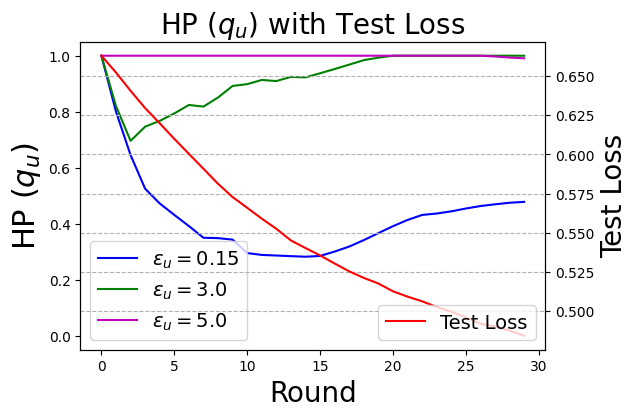

Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/online_optimization_result-losses-heart_disease-PULDP-AVG-QCTest-1.0.png


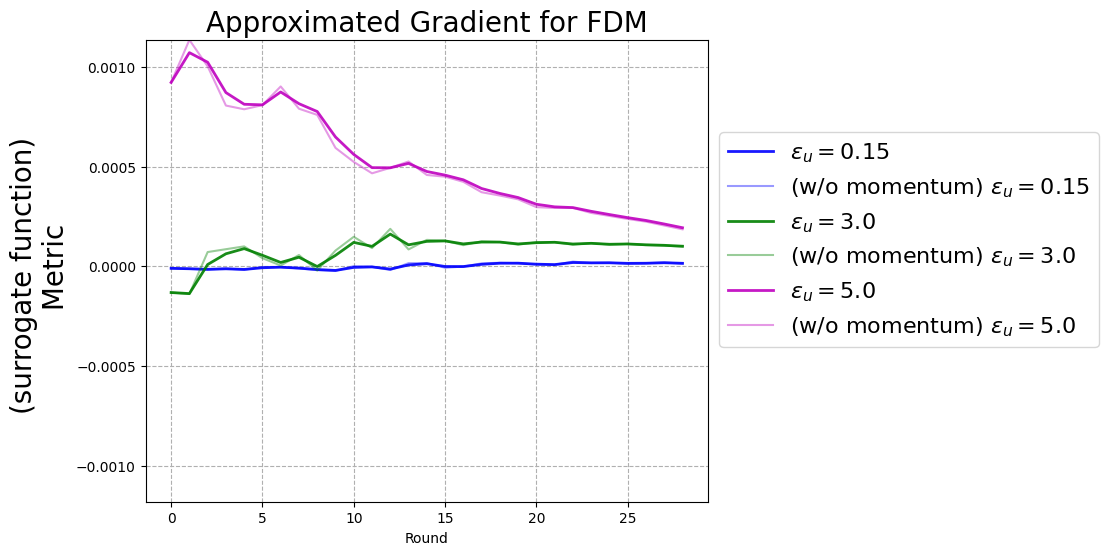

In [ ]:
logger_set_warning()
fed_sim_params = init_heart_disease_param(parallelized=True)
fed_sim_params.epsilon_list = [0.15, 3.0, 5.0]
fed_sim_params.group_thresholds = [0.15, 3.0, 5.0]
fed_sim_params.ratio_list = [0.6, 0.25, 0.15]
fed_sim_params.validation_ratio = 0.5
fed_sim_params.times = 10
fed_sim_params.agg_strategy = "PULDP-AVG-QCTest"

initial_q_u_list = [0.1, 0.5, 1.0]
momentum_weight_list = [0.5, 0.9]
for initial_q_u in initial_q_u_list:
    for momentum_weight in momentum_weight_list:
        fed_sim_params.initial_q_u = initial_q_u
        fed_sim_params.momentum_weight = momentum_weight
        run_online_optimization(fed_sim_params, force_update=False)
        x, acc_means, acc_stds = show_online_optimization_result(
            fed_sim_params, errorbar=False,
            img_name=f"{fed_sim_params.dataset_name}-{fed_sim_params.agg_strategy}-{initial_q_u}-momentum{momentum_weight}"
        )

#### QCTrain

##### different initial q_u

In [ ]:
if "hd_all_acc_results" not in locals():
    hd_all_acc_results = {}
logger_set_warning()
fed_sim_params = init_heart_disease_param(parallelized=True)
fed_sim_params.epsilon_list = [0.15, 3.0, 5.0]
fed_sim_params.group_thresholds = [0.15, 3.0, 5.0]
fed_sim_params.ratio_list = [0.6, 0.25, 0.15]
fed_sim_params.validation_ratio = 0.5
fed_sim_params.times = 10
fed_sim_params.agg_strategy = "PULDP-AVG-QCTrain"

initial_q_u_list = [0.1, 0.5, 1.0]
for initial_q_u in initial_q_u_list:
    fed_sim_params.initial_q_u = initial_q_u
    run_online_optimization(fed_sim_params, force_update=False)
    x, acc_means, acc_stds = show_online_optimization_result(
        fed_sim_params, errorbar=False,
        img_name=f"{fed_sim_params.dataset_name}-{fed_sim_params.agg_strategy}-{initial_q_u}"
    )
    hd_all_acc_results[(fed_sim_params.agg_strategy, initial_q_u)] = (x, acc_means, acc_stds)

##### ablation study: weight decay

In [ ]:
logger_set_warning()
fed_sim_params = init_heart_disease_param(parallelized=True)
fed_sim_params.epsilon_list = [0.15, 3.0, 5.0]
fed_sim_params.group_thresholds = [0.15, 3.0, 5.0]
fed_sim_params.ratio_list = [0.6, 0.25, 0.15]
fed_sim_params.validation_ratio = 0.5
fed_sim_params.times = 10
fed_sim_params.agg_strategy = "PULDP-AVG-QCTrain"
fed_sim_params.step_decay = False

initial_q_u_list = [0.1, 0.5, 1.0]
for initial_q_u in initial_q_u_list:
    fed_sim_params.initial_q_u = initial_q_u
    run_online_optimization(fed_sim_params, force_update=False)
    x, acc_means, acc_stds = show_online_optimization_result(
        fed_sim_params, errorbar=False,
        img_name=f"{fed_sim_params.dataset_name}-{fed_sim_params.agg_strategy}-{initial_q_u}-step_decay_off"
    )

##### ablation study: momentum

In [ ]:
logger_set_warning()
fed_sim_params = init_heart_disease_param(parallelized=True)
fed_sim_params.epsilon_list = [0.15, 3.0, 5.0]
fed_sim_params.group_thresholds = [0.15, 3.0, 5.0]
fed_sim_params.ratio_list = [0.6, 0.25, 0.15]
fed_sim_params.validation_ratio = 0.5
fed_sim_params.times = 10
fed_sim_params.agg_strategy = "PULDP-AVG-QCTrain"
fed_sim_params.with_momentum = False

initial_q_u_list = [0.1, 0.5, 1.0]
for initial_q_u in initial_q_u_list:
    fed_sim_params.initial_q_u = initial_q_u
    run_online_optimization(fed_sim_params, force_update=False)
    x, acc_means, acc_stds = show_online_optimization_result(
        fed_sim_params, errorbar=False,
        img_name=f"{fed_sim_params.dataset_name}-{fed_sim_params.agg_strategy}-{initial_q_u}-momentum_off"
    )

#### Baselines

##### Best HP by static optimization (PULDP-AVG)
$(\epsilon_1, \epsilon_2, \epsilon_3) => (q_u=0.1, q_u=0.7, q_u=1.0)$

02/08/2024 21:26:19:WARNING:No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Skip: File already exists.
Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/specified_idx_result-heart_disease-PULDPAVG.png


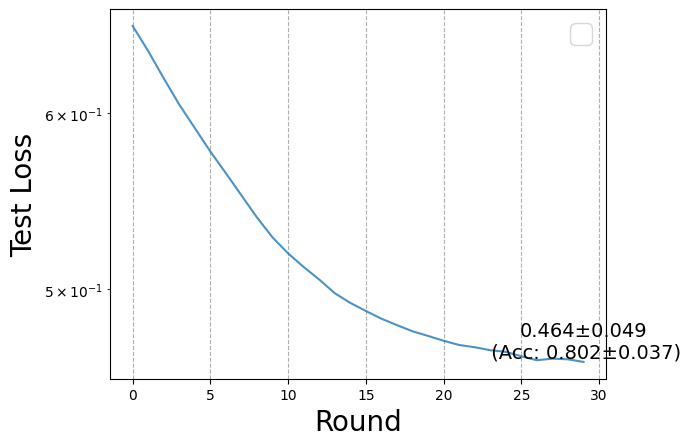

In [16]:
if "hd_all_acc_results" not in locals():
    hd_all_acc_results = {}
logger_set_warning()
fed_sim_params = init_heart_disease_param(parallelized=True)
fed_sim_params.epsilon_list = [0.15, 3.0, 5.0]
fed_sim_params.group_thresholds = [0.15, 3.0, 5.0]
fed_sim_params.ratio_list = [0.6, 0.25, 0.15]
fed_sim_params.validation_ratio = 0.5
fed_sim_params.times = 10
fed_sim_params.agg_strategy = "PULDP-AVG"
static_q_u_list = [1.0, 0.9, 0.8, 0.7, 0.5, 0.3, 0.1]
best_idx_per_group = {0.15: 6, 3.0: 3, 5.0: 0}

run_with_specified_idx(
    fed_sim_params, best_idx_per_group, 
    static_q_u_list=static_q_u_list, force_update=False
)
x, acc_means, acc_stds = show_specified_idx_result(
    fed_sim_params, best_idx_per_group, static_q_u_list=static_q_u_list, errorbar=False,
    img_name=f"{fed_sim_params.dataset_name}-PULDPAVG"
)
hd_all_acc_results[(fed_sim_params.agg_strategy, "PULDP-AVG (Offline HPO)")] = (x, acc_means, acc_stds)

##### random-updown

In [17]:
if "hd_all_acc_results" not in locals():
    hd_all_acc_results = {}

logger_set_warning()
fed_sim_params = init_heart_disease_param(parallelized=True)
fed_sim_params.epsilon_list = [0.15, 3.0, 5.0]
fed_sim_params.group_thresholds = [0.15, 3.0, 5.0]
fed_sim_params.ratio_list = [0.6, 0.25, 0.15]
fed_sim_params.validation_ratio = 0.5
fed_sim_params.times = 10
fed_sim_params.agg_strategy = "PULDP-AVG-QCTrain"
fed_sim_params.step_decay = True
fed_sim_params.hp_baseline = "random-updown"

initial_q_u_list = [0.1, 0.5, 1.0]
for initial_q_u in initial_q_u_list:
    fed_sim_params.initial_q_u = initial_q_u
    run_online_optimization(fed_sim_params, force_update=False)
    x, acc_means, acc_stds = show_online_optimization_result(
        fed_sim_params, errorbar=False,
        img_name=f"{fed_sim_params.dataset_name}-{initial_q_u}-{fed_sim_params.hp_baseline}"
    )
    hd_all_acc_results[(fed_sim_params.hp_baseline, initial_q_u)] = (x, acc_means, acc_stds)

======== TIME: 0 start
======== TIME: 1 start
======== TIME: 2 start
======== TIME: 3 start
======== TIME: 4 start
======== TIME: 5 start
======== TIME: 6 start
======== TIME: 7 start
======== TIME: 8 start
======== TIME: 9 start


##### Random

In [ ]:
if "hd_all_acc_results" not in locals():
    hd_all_acc_results = {}

logger_set_warning()
fed_sim_params = init_heart_disease_param(parallelized=True)
fed_sim_params.epsilon_list = [0.15, 3.0, 5.0]
fed_sim_params.group_thresholds = [0.15, 3.0, 5.0]
fed_sim_params.ratio_list = [0.6, 0.25, 0.15]
fed_sim_params.validation_ratio = 0.5
fed_sim_params.times = 10
fed_sim_params.agg_strategy = "PULDP-AVG-QCTrain"
fed_sim_params.step_decay = True
fed_sim_params.hp_baseline = "random"

initial_q_u_list = [0.1, 0.5, 1.0]
for initial_q_u in initial_q_u_list:
    fed_sim_params.initial_q_u = initial_q_u
    run_online_optimization(fed_sim_params, force_update=False)
    x, acc_means, acc_stds = show_online_optimization_result(
        fed_sim_params, errorbar=False,
        img_name=f"{fed_sim_params.dataset_name}-{initial_q_u}-{fed_sim_params.hp_baseline}"
    )
    hd_all_acc_results[(fed_sim_params.hp_baseline, "Random")] = (x, acc_means, acc_stds)

##### ULDP-AVG

IDX:  {0.15: 6}
======== TIME: 0 start
======== TIME: 1 start
======== TIME: 2 start
======== TIME: 3 start
======== TIME: 4 start
======== TIME: 5 start
======== TIME: 6 start
======== TIME: 7 start
======== TIME: 8 start
======== TIME: 9 start


02/08/2024 21:26:00:WARNING:No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


TEST ACC: 0.7244 ± 0.0347 , TEST LOSS: 0.5781 ± 0.0486
VALID ACC: 0.7457 ± 0.0640 , VALID LOSS: 0.5612 ± 0.1040
Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/specified_idx_result-heart_disease-ULDPAVG.png


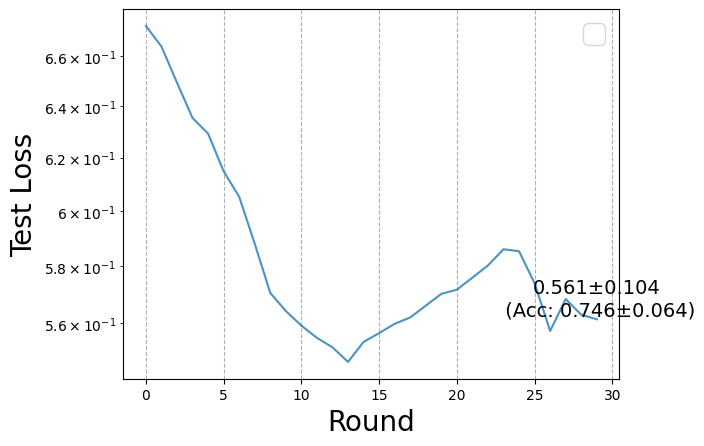

In [15]:
if "hd_all_acc_results" not in locals():
    hd_all_acc_results = {}
logger_set_warning()
fed_sim_params = init_heart_disease_param(parallelized=True)
fed_sim_params.epsilon_list = [0.15]
fed_sim_params.group_thresholds = [0.15]
fed_sim_params.ratio_list = [1.0]
fed_sim_params.validation_ratio = 0.5
fed_sim_params.times = 10
fed_sim_params.agg_strategy = "PULDP-AVG"
static_q_u_list = [1.0, 0.9, 0.8, 0.7, 0.5, 0.3, 0.1, 0.07, 0.05, 0.01]
best_idx_per_group = {0.15: 6}

run_with_specified_idx(
    fed_sim_params, best_idx_per_group, 
    static_q_u_list=static_q_u_list, force_update=False
)
x, acc_means, acc_stds = show_specified_idx_result(
    fed_sim_params, best_idx_per_group, static_q_u_list=static_q_u_list, errorbar=False,
    img_name=f"{fed_sim_params.dataset_name}-ULDPAVG"
)
hd_all_acc_results[(fed_sim_params.agg_strategy, "ULDP-AVG (Baseline)")] = (x, acc_means, acc_stds)

#### Compare all results

In [ ]:
plot_acc_results(fed_sim_params, hd_all_acc_results, initial_q_u_list=[0.1, 0.5, 1.0], errorbar=False)